Operator `Kernel` ran in 0.01 s


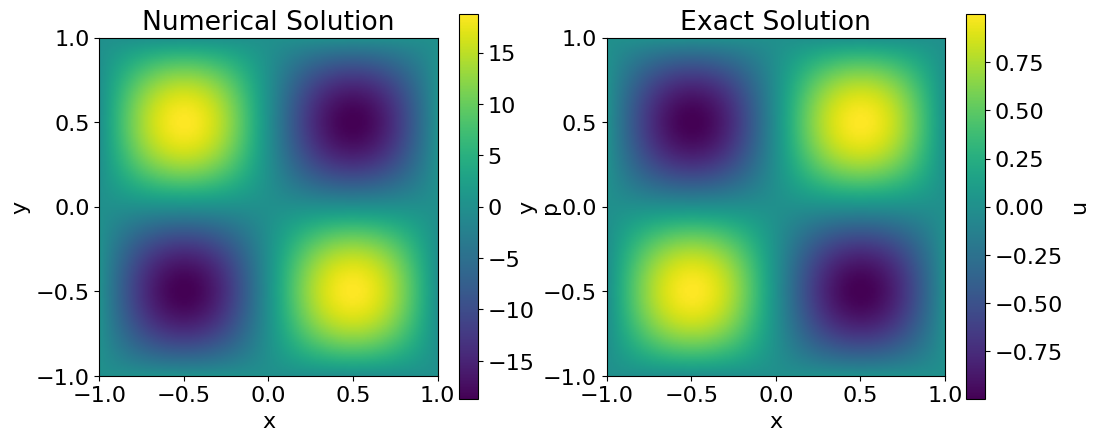

Maximum error: 19.737978618831093


In [26]:
from devito import Grid, Function, Eq, solve, Operator
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nx = 200
ny = 200
a1 = 1
a2 = 1
k = 1
extent = (-1., 1., -1., 1.)

# Create grid and functions
grid = Grid(shape=(nx, ny), extent=(extent[1] - extent[0], extent[3] - extent[2]))
p = Function(name='p', grid=grid, space_order=2)
pn = Function(name='pn', grid=grid, space_order=2)

# Define the source term q(x, y)
x_vals = np.linspace(extent[0], extent[1], nx)
y_vals = np.linspace(extent[2], extent[3], ny)
X, Y = np.meshgrid(x_vals, y_vals)
q_data = - (a1 * np.pi)**2 * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y) \
         - (a2 * np.pi)**2 * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y) \
         + k**2 * np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)

q = Function(name='q', grid=grid)
q.data[:] = q_data

# Create Helmholtz equation based on `pn`
eqn = Eq(pn.laplace + k**2 * pn - q, subdomain=grid.interior)
# Let SymPy solve for the central stencil point
stencil = solve(eqn, pn)
# Now we let our stencil populate our second buffer `p`
eq_stencil = Eq(p, stencil)

# Create boundary condition expressions (zero boundary conditions)
x, y = grid.dimensions
bc = [Eq(p[0, y], 0.)]  # p = 0 @ x = -1
bc += [Eq(p[nx-1, y], 0.)]  # p = 0 @ x = 1
bc += [Eq(p[x, 0], 0.)]  # p = 0 @ y = -1
bc += [Eq(p[x, ny-1], 0.)]  # p = 0 @ y = 1

# Now we can build the operator that we need
op = Operator(expressions=[eq_stencil] + bc)

# Execute the operator
op.apply()

# Exact solution
u_exact = np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y)

# Plot the numerical solution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(p.data, extent=(extent[0], extent[1], extent[2], extent[3]), origin='lower')
plt.colorbar(label='p')
plt.title('Numerical Solution')
plt.xlabel('x')
plt.ylabel('y')

# Plot the exact solution
plt.subplot(1, 2, 2)
plt.imshow(u_exact, extent=(extent[0], extent[1], extent[2], extent[3]), origin='lower')
plt.colorbar(label='u')
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

# Calculate the error
error = np.abs(p.data - u_exact)
print(f'Maximum error: {np.max(error)}')